### Naive vs Marla

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

In [33]:
# Path to local CSV folder
csv_folder = "/home/george/Workshop/Interference/Results/traffic_generator_csvs"

# Get all CSV files in the folder
csv_files = glob.glob(os.path.join(csv_folder, "*.csv"))

In [25]:
def plot_metric_over_time(csv_filenames, metric="P99_Latency", folder_path=csv_folder):
    """
    Plots the selected metric over time for selected CSV files, keeping only values below 20 for P99_Latency.
    
    Args:
        csv_filenames (list): List of CSV filenames (e.g., ["naive_v01.csv", "balanced_ramp.csv"]).
        metric (str): The metric column to plot (default: "P99_Latency").
        folder_path (str): Folder where the CSV files are stored.
    """
    plt.figure(figsize=(12, 6))

    for filename in csv_filenames:
        full_path = os.path.join(folder_path, filename)
        if not os.path.exists(full_path):
            print(f"Warning: File not found: {full_path}")
            continue
        
        df = pd.read_csv(full_path)
        df['Minute'] = pd.to_numeric(df['Minute'], errors='coerce')
        df[metric] = pd.to_numeric(df[metric], errors='coerce')
        df = df[df[metric] < 20]  # Keep only values below 20 
        
        label = filename.replace(".csv", "")
        plt.plot(df['Minute'], df[metric], marker='o', linewidth=2, label=label)

    plt.title(f"{metric} Over Time per Experiment")
    plt.xlabel("Minute")
    plt.ylabel(metric.replace("_", " "))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(range(1, 31))
    plt.show()

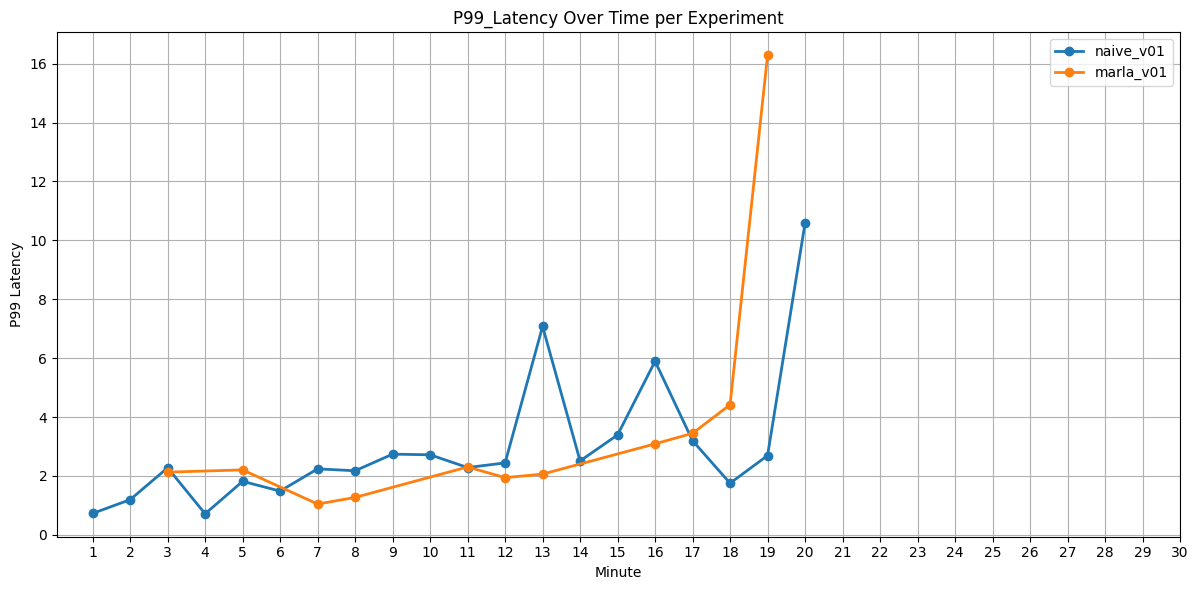

In [26]:
plot_metric_over_time(["naive_v01.csv", "marla_v01.csv"])


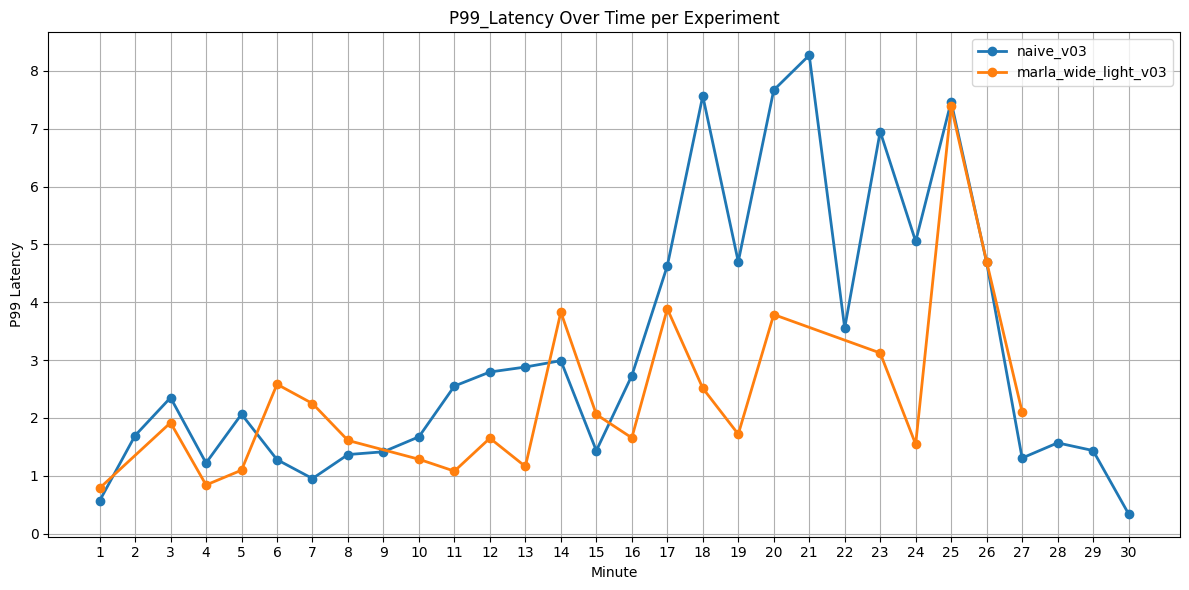

In [32]:
# plot for naive 02 and naive 03
#"marla_wide_light_v03.csv"
plot_metric_over_time(["naive_v03.csv", "marla_wide_light_v03.csv"], metric="P99_Latency")

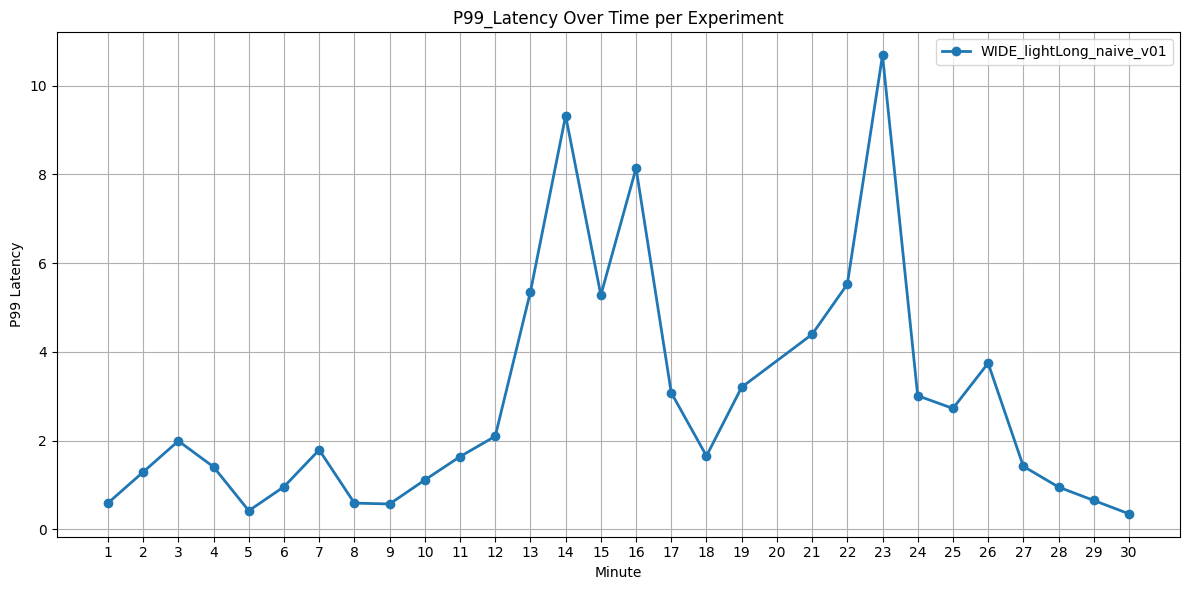

In [34]:
plot_metric_over_time(["WIDE_lightLong_naive_v01.csv"])